In [2]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn
import sklearn.preprocessing

%matplotlib inline

import pandas
import pickle
import pydot

Using TensorFlow backend.
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ankushs

# Import the two datasets

In [3]:

# import the data, Butte
dataButte = np.load('Butte_data/data_nadj4_stdTrue.npy')
dataLabelsButte = np.load('Butte_data/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsButte),1))
temp[:,0] = dataLabelsButte
dataLabelsButte = temp

# Kaweah
dataKaweah = np.load('Kaweah_data/data_nadj4_stdTrue.npy')
dataLabelsKaweah = np.load('Kaweah_data/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsKaweah),1))
temp[:,0] = dataLabelsKaweah
dataLabelsKaweah = temp

print(np.shape(dataKaweah),np.shape(dataButte))


(24523, 4, 9, 37) (23411, 4, 9, 37)


# Data processing from Noah's notebook

In [4]:
# do the do for Butte
# reshuffle the vectors
data_preped=np.transpose(dataButte, (0, 2, 3, 1))

# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Butte=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Butte)[-1]):
    for j in range(np.shape(X_Butte)[1]):
        
        # do it for all examples, for this moment
        X_Butte[:,j,:,i] = min_max_scaler.fit_transform(X_Butte[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Butte)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Butte[:,j,k,i]=X_Butte[:,j,k,i]-X_Butte[:,j,k,i]

# reshuffle the vectors for Kaweah
data_preped=np.transpose(dataKaweah, (0, 2, 3, 1))
# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Kaweah=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Kaweah)[-1]):
    for j in range(np.shape(X_Kaweah)[1]):
        
        # do it for all examples, for this moment
        X_Kaweah[:,j,:,i] = min_max_scaler.fit_transform(X_Kaweah[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Kaweah)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Kaweah[:,j,k,i]=X_Kaweah[:,j,k,i]-X_Kaweah[:,j,k,i]

                    
# combine them
X_both=np.concatenate((X_Butte,X_Kaweah),axis=0)
dataLabelsBoth=np.concatenate((dataLabelsButte,dataLabelsKaweah),axis=0)
print(np.shape(X_Butte),np.shape(X_Kaweah),np.shape(X_both))

/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ankushs/anaconda3/envs/AEM_ML/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less


(23411, 9, 37, 4) (24523, 9, 37, 4) (47934, 9, 37, 4)


# Creating mixed training and test datasets from Noah's notebook for consistency

In [5]:

# make some random indices, then take 20000 examples for training and the rest for test, results in about 85/15 split
# first is butte on butte
indices=np.random.permutation(X_Butte.shape[0])
X_train1=X_Butte[indices[:20000],:,:,:]
X_test1=X_Butte[indices[20000:],:,:,:]
Y_train1=dataLabelsButte[indices[:20000],:]
Y_test1=dataLabelsButte[indices[20000:],:]

# 2nd is Kaweah on Kaweah
indices=np.random.permutation(X_Kaweah.shape[0])
X_train2=X_Kaweah[indices[:20000],:,:,:]
X_test2=X_Kaweah[indices[20000:],:,:,:]
Y_train2=dataLabelsKaweah[indices[:20000],:]
Y_test2=dataLabelsKaweah[indices[20000:],:]

# 3rd is both on both
indices=np.random.permutation(X_both.shape[0])
X_train3=X_both[indices[:41000],:,:,:]
X_test3=X_both[indices[41000:],:,:,:]
Y_train3=dataLabelsBoth[indices[:41000],:]
Y_test3=dataLabelsBoth[indices[41000:],:]

# 4th is butte on Kaweah
X_train4=X_Butte
X_test4=X_Kaweah
Y_train4=dataLabelsButte
Y_test4=dataLabelsKaweah

# 5th is Kaweah on Butte
X_train5=X_Kaweah
X_test5=X_Butte
Y_train5=dataLabelsKaweah
Y_test5=dataLabelsButte

# 6th is butte with 0.5% of Kaweah
percentToUse=0.5
indices=np.random.permutation(X_Kaweah.shape[0])
X_train6=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test6=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train6=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test6=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 7th is butte with 1% of Kaweah
percentToUse=1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train7=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test7=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train7=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test7=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 8th is butte with 0.1% of Kaweah
percentToUse=0.1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train8=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test8=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train8=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test8=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]


# Print an example
print ("number of training examples = " + str(X_train1.shape[0]))
print ("number of test examples = " + str(X_test1.shape[0]))
print ("X_train1 shape: " + str(X_train1.shape))
print ("Y_train1 shape: " + str(Y_train1.shape))
print ("X_test1 shape: " + str(X_test1.shape))
print ("Y_test1 shape: " + str(Y_test1.shape))


number of training examples = 20000
number of test examples = 3411
X_train1 shape: (20000, 9, 37, 4)
Y_train1 shape: (20000, 1)
X_test1 shape: (3411, 9, 37, 4)
Y_test1 shape: (3411, 1)


# Defining the layers in the simple fc only 3 layer model

In [6]:

def fc_only_model(input_shape):

     model = keras.models.Sequential()
    
    # make the initializer
   
     initToUse=keras.initializers.he_normal(seed=1)
     model.add(Flatten())
     model.add(Dense(250, activation='relu',kernel_initializer=initToUse))
     model.add(Dense(100, activation='relu', kernel_initializer=initToUse))
     model.add(Dense(35, activation='relu', kernel_initializer=initToUse))
     model.add(Dense(1, activation='sigmoid', kernel_initializer=initToUse))
    
     return model



# Defining the model run and computing accuracy on test set

In [7]:
def run_compute_model(X_train, Y_train, X_test, Y_test):

    fc_model = fc_only_model(X_train.shape[1:])
    fc_model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])
    fc_model.fit(X_train, Y_train, epochs=40, batch_size=500, verbose=False)
    pred = fc_model.evaluate(x=X_test, y=Y_test)
    accuracy = pred[1]

    return accuracy

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 1332)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 250)               333250    
_________________________________________________________________
dense_67 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_68 (Dense)             (None, 35)                3535      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 36        
Total params: 361,921
Trainable params: 361,921
Non-trainable params: 0
_________________________________________________________________
None


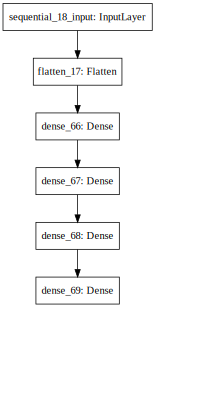

In [30]:
 
from keras.utils.vis_utils import plot_model
fc_model = fc_only_model(X_train1.shape[1:])
plot_model(fc_model, to_file='model_plot.png', dpi=400, show_shapes=True, show_layer_names=True)
fc_model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])
fc_model.fit(X_train1, Y_train1, epochs=40, batch_size=500, verbose=False)
print(fc_model.summary())
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(fc_model).create(prog='dot', format='svg'))

# Fit datasets to different training and evaluate over corresponding test sets

In [8]:
Accuracy_set1 = run_compute_model(X_train1, Y_train1, X_test1, Y_test1)
Accuracy_set2 = run_compute_model(X_train2, Y_train2, X_test2, Y_test2)
Accuracy_set3 = run_compute_model(X_train3, Y_train3, X_test3, Y_test3)
Accuracy_set4 = run_compute_model(X_train4, Y_train4, X_test4, Y_test4)
Accuracy_set5 = run_compute_model(X_train5, Y_train5, X_test5, Y_test5)
Accuracy_set6 = run_compute_model(X_train6, Y_train6, X_test6, Y_test6)
Accuracy_set7 = run_compute_model(X_train7, Y_train7, X_test7, Y_test7)
Accuracy_set8 = run_compute_model(X_train8, Y_train8, X_test8, Y_test8)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
24038/24038 [==============================] - 1s 39us/step


# Print Accuracies

In [9]:
print("Set 1 accuracy: ", str(Accuracy_set1))
print("Set 2 accuracy: ", str(Accuracy_set2))
print("Set 3 accuracy: ", str(Accuracy_set3))
print("Set 4 accuracy: ", str(Accuracy_set4))
print("Set 5 accuracy: ", str(Accuracy_set5))
print("Set 6 accuracy: ", str(Accuracy_set6))
print("Set 7 accuracy: ", str(Accuracy_set7))
print("Set 8 accuracy: ", str(Accuracy_set8))

Set 1 accuracy:  0.9994136691093445
Set 2 accuracy:  0.9955781698226929
Set 3 accuracy:  0.9734640717506409
Set 4 accuracy:  0.5905476212501526
Set 5 accuracy:  0.23177139461040497
Set 6 accuracy:  0.8993573784828186
Set 7 accuracy:  0.9350886940956116
Set 8 accuracy:  0.5868208408355713


# Plot loss vs number of epochs for training and hold out CV set

In [21]:
# create model
check_model = keras.models.Sequential()
check_model.add(Flatten())
check_model.add(Dense(25, activation='relu'))
check_model.add(Dense(100, activation='relu'))
check_model.add(Dense(1, activation='sigmoid'))

# Compile model
check_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = check_model.fit(X_train1, Y_train1, validation_split=0.1, epochs=40, batch_size=500, verbose=True)
# list all data in history
print(history.history.keys())


Train on 18000 samples, validate on 2000 samples
Epoch 1/40
18000/18000 [==============================] - 1s 41us/step - loss: 0.4448 - accuracy: 0.8186 - val_loss: 0.4029 - val_accuracy: 0.8505
Epoch 2/40
18000/18000 [==============================] - 0s 20us/step - loss: 0.3491 - accuracy: 0.8646 - val_loss: 0.3263 - val_accuracy: 0.8635
Epoch 3/40
18000/18000 [==============================] - 0s 24us/step - loss: 0.2631 - accuracy: 0.8973 - val_loss: 0.2505 - val_accuracy: 0.9155
Epoch 4/40
18000/18000 [==============================] - 0s 22us/step - loss: 0.2004 - accuracy: 0.9348 - val_loss: 0.1997 - val_accuracy: 0.9310
Epoch 5/40
18000/18000 [==============================] - 0s 22us/step - loss: 0.1592 - accuracy: 0.9554 - val_loss: 0.1539 - val_accuracy: 0.9595
Epoch 6/40
18000/18000 [==============================] - 0s 23us/step - loss: 0.1271 - accuracy: 0.9718 - val_loss: 0.1260 - val_accuracy: 0.9690
Epoch 7/40
18000/18000 [==============================] - 0s 24us/ste

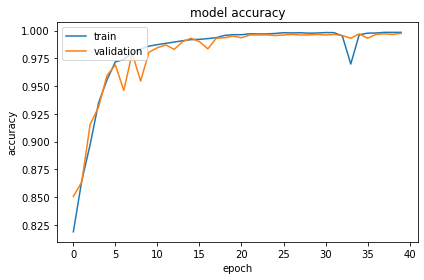

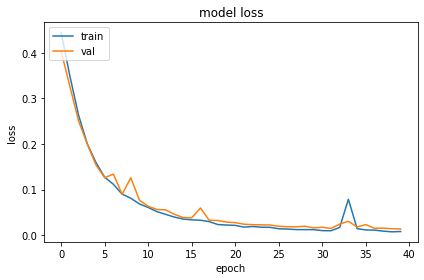

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig('Train_val_accuracy_FFN.png',dpi=400)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.savefig('Train_val_loss_FFN.png',dpi=400)
plt.show()



# Check the data shape works

In [12]:
alt_X_train8=X_train8.reshape( X_train8.shape[0],-1)
alt_X_test8= X_test8.reshape( X_test8.shape[0],-1)

alt_X_train7=X_train7.reshape( X_train7.shape[0],-1)
alt_X_test7= X_test7.reshape( X_test7.shape[0],-1)

alt_X_train6 =X_train6.reshape( X_train6.shape[0],-1)
alt_X_test6 = X_test6.reshape( X_test6.shape[0],-1)

alt_X_train5 =X_train5.reshape( X_train5.shape[0],-1)
alt_X_test5 = X_test5.reshape( X_test5.shape[0],-1)


Train on 21506 samples, validate on 2390 samples
Epoch 1/40
21506/21506 [==============================] - 1s 43us/step - loss: 0.4049 - accuracy: 0.8369 - val_loss: 0.3988 - val_accuracy: 0.8285
Epoch 2/40
21506/21506 [==============================] - 1s 26us/step - loss: 0.2726 - accuracy: 0.8928 - val_loss: 0.3402 - val_accuracy: 0.8870
Epoch 3/40
21506/21506 [==============================] - 1s 25us/step - loss: 0.1966 - accuracy: 0.9340 - val_loss: 0.4405 - val_accuracy: 0.8393
Epoch 4/40
21506/21506 [==============================] - 0s 23us/step - loss: 0.1423 - accuracy: 0.9604 - val_loss: 0.3901 - val_accuracy: 0.8573
Epoch 5/40
21506/21506 [==============================] - 1s 26us/step - loss: 0.1052 - accuracy: 0.9727 - val_loss: 0.6577 - val_accuracy: 0.8138
Epoch 6/40
21506/21506 [==============================] - 1s 25us/step - loss: 0.1281 - accuracy: 0.9574 - val_loss: 0.2174 - val_accuracy: 0.9318
Epoch 7/40
21506/21506 [==============================] - 1s 24us/ste

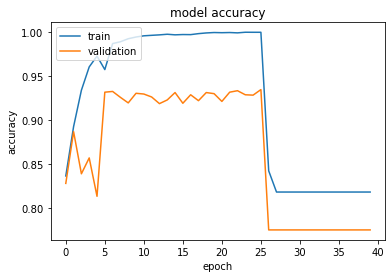

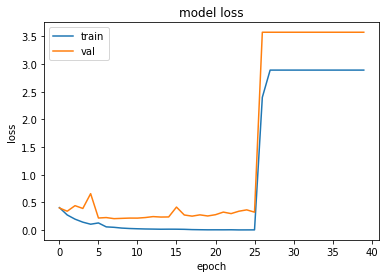

In [13]:
ver_model = keras.models.Sequential()
initToUse=keras.initializers.he_normal(seed=1)
ver_model.add(Dense(250, input_shape=alt_X_train8.shape[1:], activation='relu', kernel_initializer=initToUse))
ver_model.add(Dense(100, activation='relu', kernel_initializer=initToUse))
ver_model.add(Dense(35, activation='relu', kernel_initializer=initToUse))
ver_model.add(Dense(1, activation='sigmoid', kernel_initializer=initToUse))

# Compile model
ver_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = ver_model.fit(alt_X_train8, Y_train8, validation_split=0.1, epochs=40, batch_size=500, verbose=True)
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
alt_pred = ver_model.evaluate(x=alt_X_test8, y=Y_test8)
y_comp = np.round(ver_model.predict(alt_X_test8))

24038/24038 [==============================] - 1s 36us/step


In [15]:
print("Accuracy = :", str(alt_pred[1]))

Accuracy = : 0.5868208408355713


In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# confusion matrix
matrix = confusion_matrix(Y_test8, y_comp)
print(matrix)


[[    0  9932]
 [    0 14106]]


# Random forest classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=100,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
forest_classifier.fit(alt_X_train5, np.ravel(Y_train5))
print(forest_classifier.feature_importances_)
pred_label_test = forest_classifier.predict(alt_X_test5)

[0.00133522 0.00042842 0.         ... 0.         0.         0.        ]


In [18]:
print("Accuracy:",metrics.accuracy_score(Y_test5, pred_label_test))
#print(metrics.confusion_matrix(y_test, pred_label_test))
#print(metrics.cohen_kappa_score(y_test, pred_label_test))
#print(metrics.roc_auc_score(y_test, pred_label_test))

Accuracy: 0.3545341933279228
